# JupyterHub Notebook

### This notebook server is hosted on the OpenShift platform which provides a separate server for each individual user. The platform takes care of the provisioning of the server and allocating related to storage.


In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import watermark
# import s3fs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from minio import Minio
from verta import Client
from minio.error import ResponseError
import os
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

# import tools as tools
%matplotlib inline
%load_ext watermark

In [2]:
%watermark -n -v -m -g -iv


seaborn    0.11.0
matplotlib 3.3.3
watermark  2.0.2
numpy      1.19.4
pandas     1.1.5
Wed Dec 16 2020 

CPython 3.6.8
IPython 7.16.1

compiler   : GCC 8.3.1 20191121 (Red Hat 8.3.1-5)
system     : Linux
release    : 4.18.0-193.29.1.el8_2.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 32
interpreter: 64bit
Git hash   : df2a872e605c3b4fb5ba00b5e1363464b6f84b06


In [4]:
def get_s3_server():
    minioClient = Minio('minio-ml-workshop:9000',
                    access_key='minio',
                    secret_key='minio123',
                    secure=False)

    return minioClient

### In this next section, on the second line, insert the value you retrieved from Minio object storage earlier - representing the fully qualified name of your csv file in Minio. This is the file pushed by the data engineer in the format: full_data_csv{USERNAME}/{FILENAME}.csv. In my case this value is: full_data_csvuser29/part-00000-59149e08-583c-46a5-bfa0-0b3abecbf1a3-c000.csv (yours will be different)
### We refer to this fully qualified name in the Github instructions as CSV-FILE

In [5]:
minioClient = get_s3_server()
data_file = minioClient.fget_object("data", "full_data_csvuser29/part-00000-59149e08-583c-46a5-bfa0-0b3abecbf1a3-c000.csv", "/tmp/data.csv")
data_file_version = data_file.version_id
data = pd.read_csv('/tmp/data.csv')
data.head(5)


,customerID,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,tenure
0,148,Yes,No,DSL,No,No,No,No,No,No,...,Yes,Electronic check,45.65,45.65,Yes,Male,0,No,No,1
1,463,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,...,No,Electronic check,101.15,385.90,Yes,Male,0,Yes,Yes,4
2,471,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,...,No,Mailed check,20.65,330.60,No,Female,1,No,No,17
3,496,No,No phone service,DSL,No,Yes,Yes,No,No,Yes,...,Yes,Bank transfer (automatic),43.75,903.60,Yes,Male,0,No,No,22
4,833,Yes,No,DSL,Yes,Yes,Yes,Yes,No,Yes,...,No,Credit card (automatic),74.10,5222.30,No,Female,0,Yes,Yes,70


### Use pandas.DataFrame functions
- _shape_ to return the dimensionality
- _info_ to print a concise summary of the DataFrame
- _describe_ to generate descriptive statistics of the DataFrame's columns
- _isnull().sum()_ to sum the empty values
- finally determine Churn and Total Changes 


In [6]:
data.shape

(7043, 21)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   int64  
 1   PhoneService      7043 non-null   object 
 2   MultipleLines     7043 non-null   object 
 3   InternetService   7043 non-null   object 
 4   OnlineSecurity    7043 non-null   object 
 5   OnlineBackup      7043 non-null   object 
 6   DeviceProtection  7043 non-null   object 
 7   TechSupport       7043 non-null   object 
 8   StreamingTV       7043 non-null   object 
 9   StreamingMovies   7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7032 non-null   float64
 15  Churn             7043 non-null   object 
 16  gender            7043 non-null   object 


In [8]:
data.describe()

,customerID,MonthlyCharges,TotalCharges,SeniorCitizen,tenure
count,7043.000000,7043.000000,7032.000000,7043.000000,7043.000000
mean,3522.000000,64.761692,2283.300441,0.162147,32.371149
std,2033.283305,30.090047,2266.771362,0.368612,24.559481
min,1.000000,18.250000,18.800000,0.000000,0.000000
25%,1761.500000,35.500000,401.450000,0.000000,9.000000
50%,3522.000000,70.350000,1397.475000,0.000000,29.000000
75%,5282.500000,89.850000,3794.737500,0.000000,55.000000
max,7043.000000,118.750000,8684.800000,1.000000,72.000000


In [9]:
data.isnull().sum()

customerID           0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
dtype: int64

Text(0, 0.5, 'Count')

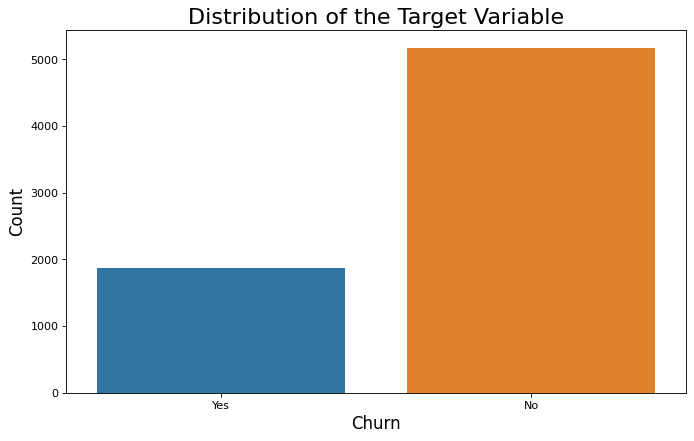

In [10]:
fig = plt.figure(figsize=(10,6), dpi=80)
ax = sns.countplot(x="Churn", data=data)
ax.set_title('Distribution of the Target Variable', fontsize=20)
ax.set_xlabel('Churn', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)

In [12]:
# Convert binary variable into numeric so plotting is easier. We need to later take mean
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

Text(0.5, 1.0, 'Churn count by Contract')

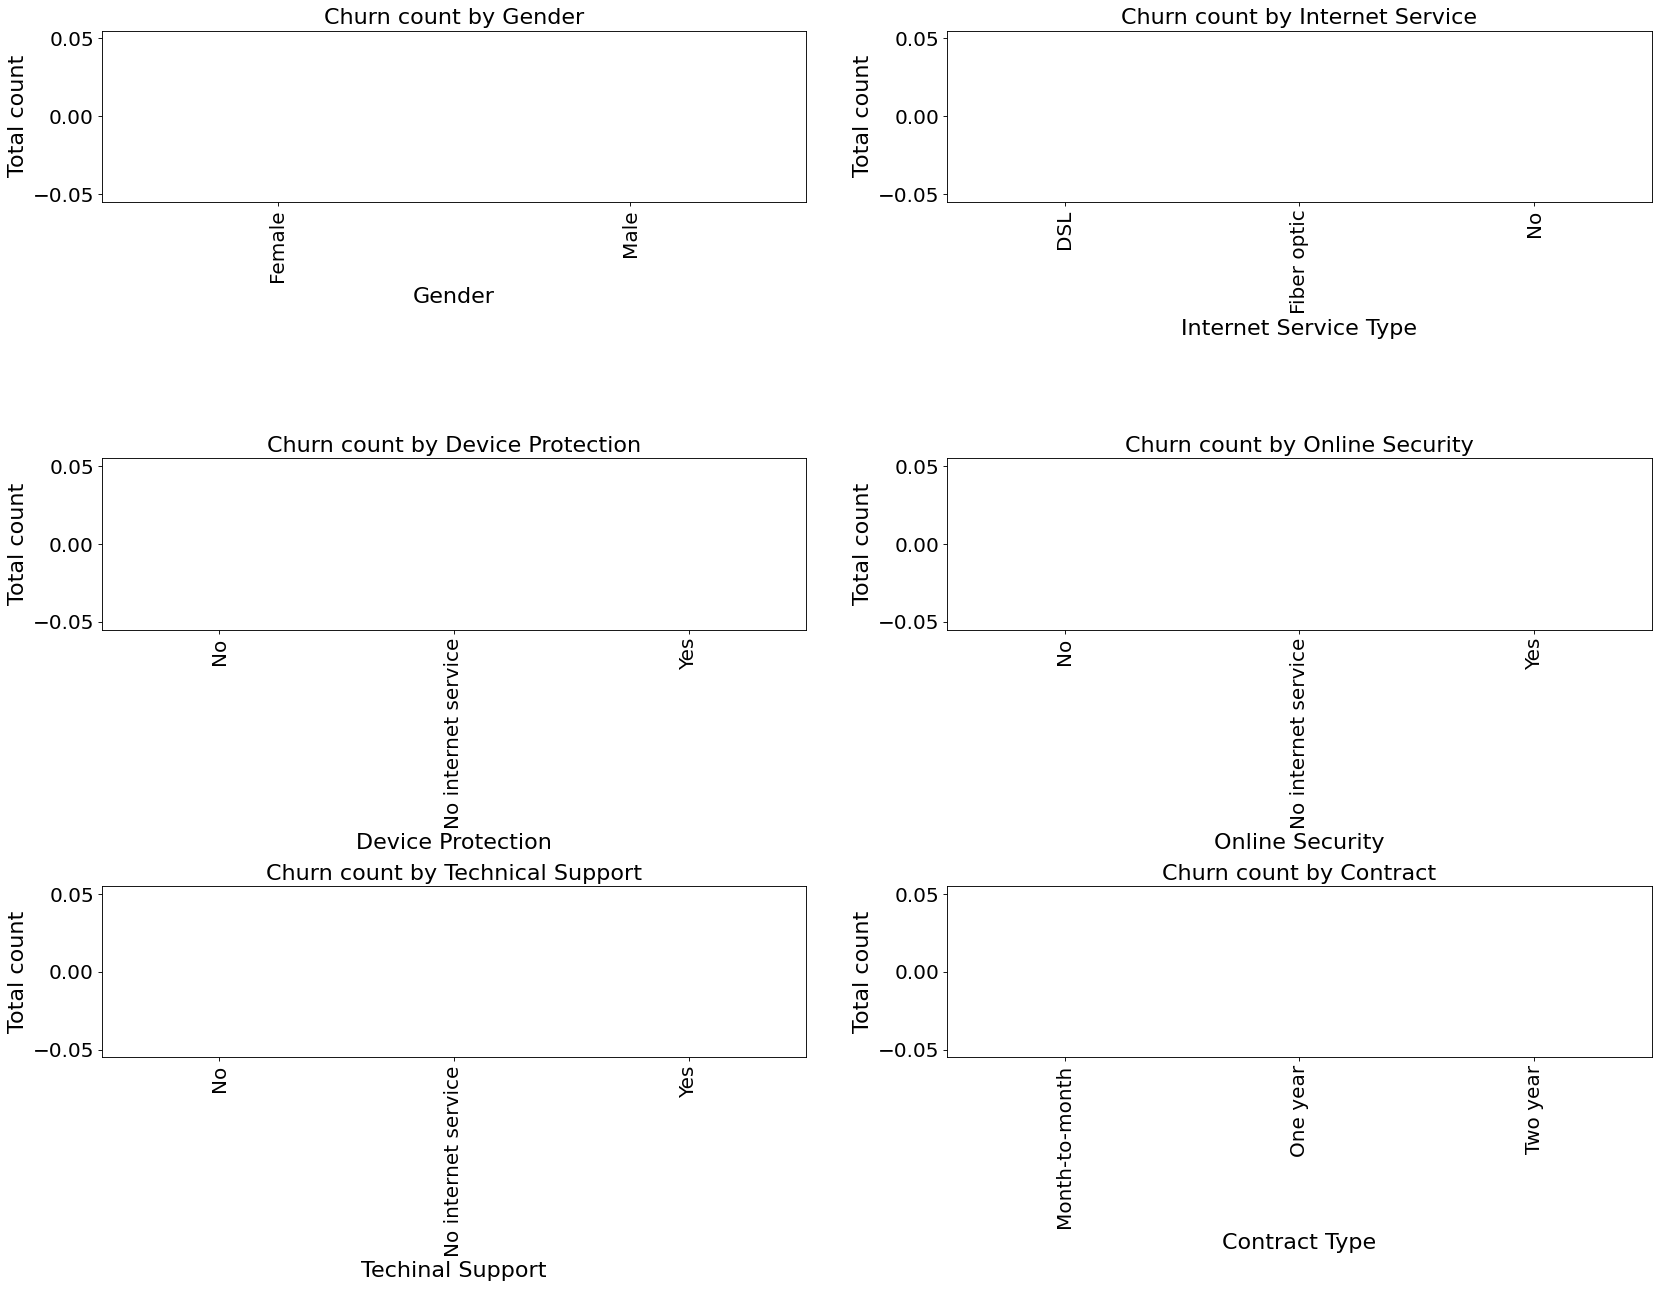

In [13]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(25,17), dpi = 80)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None ,wspace=None, hspace=1.5)
plt.rc('xtick', labelsize = 12)    # fontsize of the tick labels
plt.rc('ytick', labelsize = 12)

data.groupby('gender').Churn.sum().plot(kind='bar', ax = ax1)
ax1.set_ylabel('Total count',fontsize = 20)
ax1.set_xlabel('Gender',fontsize = 20)
ax1.tick_params(labelsize = 18)
ax1.set_title('Churn count by Gender',fontsize = 20)

data.groupby('InternetService').Churn.sum().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Total count',fontsize = 20)
ax2.set_xlabel('Internet Service Type',fontsize = 20)
ax2.tick_params(labelsize = 18)
ax2.set_title('Churn count by Internet Service',fontsize = 20)

data.groupby('DeviceProtection').Churn.sum().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Total count',fontsize = 20)
ax3.set_xlabel('Device Protection',fontsize = 20)
ax3.tick_params(labelsize = 18)
ax3.set_title('Churn count by Device Protection',fontsize = 20)

data.groupby('OnlineSecurity').Churn.sum().plot(kind='bar', ax=ax4)
ax4.set_ylabel('Total count',fontsize = 20)
ax4.set_xlabel('Online Security',fontsize = 20)
ax4.tick_params(labelsize = 18)
ax4.set_title('Churn count by Online Security',fontsize = 20)

data.groupby('TechSupport').Churn.sum().plot(kind='bar',ax=ax5)
ax5.set_ylabel('Total count',fontsize = 20)
ax5.set_xlabel('Techinal Support',fontsize = 20)
ax5.tick_params(labelsize = 18)
ax5.set_title('Churn count by Technical Support',fontsize = 20)

data.groupby('Contract').Churn.sum().plot(kind='bar',ax=ax6)
ax6.set_ylabel('Total count',fontsize = 20)
ax6.set_xlabel('Contract Type',fontsize = 20)
ax6.tick_params(labelsize = 18)
ax6.set_title('Churn count by Contract',fontsize = 20)


In [14]:
data.replace(" ", np.nan, inplace=True)

In [15]:
data.isna().sum()

customerID             0
PhoneService           0
MultipleLines          0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
Churn               7043
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
dtype: int64

In [16]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [17]:
mean = data['TotalCharges'].mean()
data.fillna(mean, inplace=True)
# Now we know that total charges has nan values
data.isna().sum()

customerID          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
dtype: int64

Text(17.644618055555554, 0.5, 'Total Charges')

<Figure size 800x640 with 0 Axes>

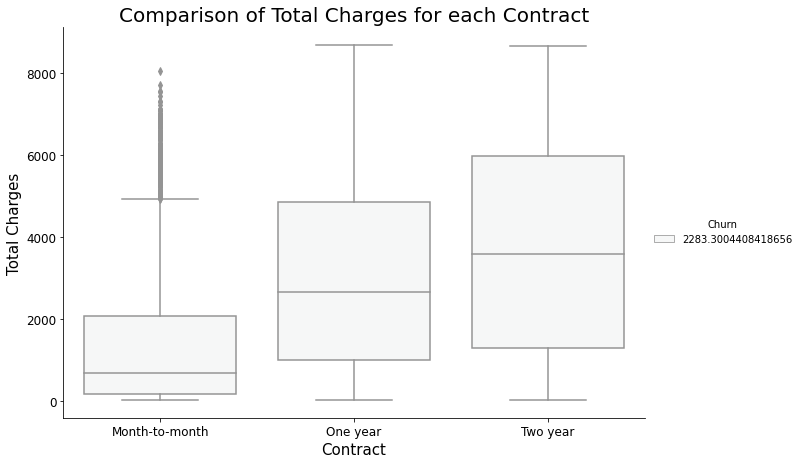

In [18]:
plt.figure(figsize=(10,8), dpi=80)
# Sns.set(rc={'figure.figsize':(25,15)})
ax = sns.catplot(x="Contract", y="TotalCharges", hue="Churn", kind="box", data=data, height = 6,aspect = 1.5,palette = 'RdBu')
plt.title('Comparison of Total Charges for each Contract',fontsize = 20)
plt.xlabel('Contract',fontsize = 15)
plt.ylabel('Total Charges',fontsize = 15)